This notebook implements and **simulates a 1D continuous attractor network** (two-ring architecture) to reproduce the qualitative behavior of **Fig. 4c–4d** in *Neupane, Fiete & Jazayeri (2024)*.

# From LM-GC Plasticity Model to CAN model of Grid cells
The Toy Plasticity Model was an auto-associative $1D$ model whose goal was to:
- Give the system a LM unit that is able to recognize periodicity and phase of landmarks
- Learns and represents the internal landmark phases matching external rhythm
- Generates internal landmark drive even when external signal is not visible

In other words, LM teaches the brain which internal module has the correct frequency and which phase in that model aligns with the external landmark, and after learning, LM can fire at the right times even without sensory landmarks.

### Given that an internal landmark signal exists, how does it shape the dynamics of a CAN and the variability of timing?
What we add here:
- A **Burak & Fiete–style CAN** (ring attractor) that supports **velocity-driven bump motion** (path integration).
- A **Neupane et al.–style internal-landmark “reset/correction” input** that can reduce drift/variance.

We'll be explicit about what comes from which model:

- **[BF09-like]**: Mexican-hat recurrent kernel on a ring + asymmetric shifts in the two populations + velocity gain that biases left vs right population.
- **[NFJ24 new]**: internal landmark inputs that are triggered *endogenously* at learned phases, with a temporally-shaped amplitude envelope.


The goal of this implementation is to show the effects of endogenous landmarks on **path integration** and **timing** and **simulate the post-learning scenario**.

In other words, **how learned endogenous landmarks interact with an existing CAN**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from typing import Sequence, Dict, Any, Tuple
import importlib

## 0. CAN Model - Conceptual description
The CAN model is a **$1D$ continuous attractor network** that:

- forms and maintains a **localized activity bump** on a ring of neurons
- keeps the bump **stable** (preserves shape, only translates it around the ring)
- optionally receives **internal landmark inputs** at specific phases on the ring
- produces bump trajectories and reaction times (time to reach an end phase)

A canonical CAN: (all CANs??? what's the definition?)
- has neurons arranged on a *ring* ($1D$ circular manifold)
- has **translation invariant connectivity** (each neuron excites near neighbors inhibits far ones)
- supports a **stable bump of activity**:
    - a localized hill of firing that can move smoothly along the ring
- bump position $\leftrightarrow$ internal representation of a variable (eg. phase, time, location)


## Attractor bump activity pattern (phase)
With a DoG kernel + global drive, the ring settles into a **periodic activity pattern** (multiple peaks); the network state is best described as the **translation phase** of the entire pattern around the ring.

Tracking the position of the bump centers (peaks) in time is a way to model **path integration**: in the CAN, the whole pattern translates smothly along the ring according to a **noisy velocity input**.

Because the network exhibits a periodic multi-peak pattern, we define the network state as the position of the next activity peak ahead of the previously tracked one, following the procedure in Neupane et al. (2024). We detect local maxima in a forward window and select the first peak.”

- How does NFJ24 track the 'exact state', given that there are multiple peaks?
    - their code updates $\text{nn\_state}[t]$ using the **first peak ahead of last tracked location**
    - This implicitly defines 'state' as the location of a particular reference peak as it advances through the ring. seems valid because:
        - the whole periodic pattern shifts coherently
        - the ordering of the peaks around the ring is consistent
        - avoids confusion or mbiguity when peaks are similar in height
    - $\text{nn\_state}[t] \in \{0, \dots, K-1\}$

- This tracked $\text{nn\_state}$ is the **1D path-integrated variable** used for:
    - stopping the trial when the bump reaches an `end_phase`
    - triggering internal landmark inputs when the bump crosses learned landmark phases







## 1. Network architecture
We model a single module as an independent ring attractor.

- ### 1.1 Ring populations
    We simulate **two populations** (Left and Right), representing two directionally biased copies of the same $1D$ module, each with **K neurons** arranged on a ring.\
    The purpose is to implement **directional translation** of the activity pattern

    - $s(t) ∈ R^{2K}$: network state (activity), concatenated as $[s_L(t), s_R(t)]$
    - $s_L(t) ∈ R^{K}$: left ring activity
    - $s_R(t) ∈ R^{K}$: right ring activity


- ### 1.2 Mexican-hat connectivity matrix (Difference of Gaussians)
    We define a 1D lateral connectivity kernel on the ring

    $\text{MexHat}[k] = A_{\text{exc}}\exp(-s_{\text{exc}}z^2_k) - A_{\text{inh}}\exp(-s_{\text{inh}}z^2_k)$

    - $z_k \in \{-\frac{K}{2}, \dots, \frac{K}{2}-1\}$ is the circular distance
    - $A_{\text{exc}}$, $A_{\text{inh}}$ are amplitudes
    - $s_{\text{exc}}$, $s_{\text{inh}}$ are control widths

    This kernel has:
    - local excitation (narrow Gaussian)
    - broader inhibition (larger Gaussian)

    It ensures a **single stable pattern of bumps** and is built such that **neighbours excite neighbours**:
    - Neurons near bump center must excite each other to maintain bump height
    - Neurons far away must inhibit each other to prevent multiple bumps from appearing

- ### 1.3 Directionally biased synapses

    We build four $K \times K$ weight matrices such that each row $i$ defines **incoming** weights onto neuron $i$, depending on the interacting type of populations:
    - **2 Directional**: they create a **bump drift** (clockwise for right direction, counterclockwise for left)
        - $W_{RR}$: $R \leftarrow R$, shifted by $-1$
        - $W_{LL}$: $L \leftarrow L$, shifted by $+1$

    - 2 coupling the two populations: enforce a single bump is shared between L and R
        - $W_{RL}$: $R \leftarrow L$ (unshifted weight)
        - $W_{LR}$: $L \leftarrow R$ (unshifted)
    
    

**Why this architecture produces a moving bump**:
This makes the model a continuous attractor network with **direction selectivity** $\mapsto$ (L -> L weights shifted one way / R->R weights shifted the other way makes a stable pattern that moves when you bias a population relative to the other)

## From BF09 to NFJ24:
- According to Burak & Fiete ring attractor: **kernel + shifted weights + velocity gain + low-pass update**
    - Two coupled populations with slightly different recurrent connectivity (purpose: *directional motion)*
    - Recurrent Mexican-hat connectivity stabilizes a single pattern of activity
    - Oppositely shifted recurrent weights: make the stable pattern move when you bias a population relative to the other
    - Velocity modulation can amplify one population's activity and suppress the other $\rightarrow$ the bump pattern translates in a controlled direction in response to velocity
    - Low-pass dynamics smooth the motion + ReLU
    
- NFJ24 becomes:
    - Learning of internal landmark (LM-GC plasticity model)
    - Additional internal landmark input $I_\text{int}$ to the CAN during simulation
        - transient
        - phase-specific
        - learned from the plasticity model
    - Time envelope for landmark-triggered input: choice to implement a *kick / reset* effect
    - Velocity tuning procedures to match behavioral timing


## 2. Parameters

- ### Initialization parameters:

    Initiate class CAN_Network using structural parameters, which follow *Burak & Fiete (2009)*
    - $K$: (364) number of ring neurons in a population

    - Numerics: 
        - $dt$: step size of numerical integration (s)
        - $\tau_s$: synaptic time constant (s)

    - Drive    
        - $\beta_{\text{vel}}$: gain on velocity input (controls how strongly the bump moves per unit velocity)
        - $\beta_0$: global feedforward excitatory drive amplitude (sets how excitable the network is)
    
    - mexhat: built using connectivity shape parameters: 
        - $A_{\text{exc}}$, $A_{\text{inh}}$ 
        - $s_{\text{exc}}$, $s_{\text{inh}}$

- ### Task-specific parameters:
    - baseline speeds used to compute velocity input $v(t)$, which is a noisy velocity input that is computed then kept constant per-trial
        - $\text{wolm\_speed}$: without internal landmarks
        - $\text{wlm\_speed}$: with internal landmarks
    - $\text{wm}$: Weber fraction controlling speed noise

    - $\text{landmark\_input\_loc}$: array of neuron indices indicating the phases at which endogenous landmarks are stored


*RK)* the paper doesn't go parameter-by-parameter with biological justification. They say that the CAN was adapted from *Burak & Fiete* + they did grid searches over velocity to match the behavioral periodicity and ensure robustness across Weber fractions

Eg. $\beta_{\text{vel}}$ was calibrated so that with the chosen speeds $\text{wolm}$ $\text{wlm}$ the model reproduces the $\sim 0.65s$ periodicity and matched mean time to target

# 3. CAN Simulation

It assumes a full CANNetwork with attributes $K$, $dt$, $\tau_s$, $\beta_\text{vel}$, $\beta_0$, $FF_\text{global}$, $W_\text{RR}$, $W_\text{LL}$, $W_\text{RL}$, $W_\text{LR}$.

At time step $t$ we compute:
- One **noisy velocity sample** per trial and keep it constant over time: $v(t)= v_\text{base} + v_\text{noise}$
    - with landmarks $\rightarrow$ $v_\text{base} = \text{wlm\_speed}$
    - without landmarks $\rightarrow$ $v_\text{base} = \text{wolm\_speed}$
- Left ring and right ring activity $s_L$, $s_R$ 
- **Velocity gains**:
    - $v_L = 1 - \beta_{\text{vel}} * v(t)$
    -  $v_L = 1 + \beta_{\text{vel}} * v(t)$
    - modulate how strongly the recurrent input moves the bump left / right
- **Recurrent input** (vectors in $\mathbb{R}^K$)
    - $g_{\text{LR}} = <W_{LR}, s_R>$,   $g_\text{LL} = <W_{LL}, s_L>$
    - $g_{\text{RR}} = <W_{RR}, s_R>$,   $g_\text{RL} = <W_{RL}, s_L>$
    - represent how neurons from either population excite each others (e.g. how R neurons influence L and viceversa for all combinations)
- **Pre-activation currents**
    - $G = [G_L, G_R]$  
    - $G_L$: $v_L \times (g_{LL} + g_{LR} + FF_{\text{global}}) + \text{lm\_input}$,
        - total contribution into the left ring neurons 
    - $G_R$: $v_R \times (g_{RL} + g_{RR} + FF_{\text{global}}) + \text{lm\_input}$,
        - 'into-right direction contribution'
- **Activation / firing rate**  
    - $F = \text{ReLU(G)}$
    - Burak & Fiete use a threshold-linear (ReLU) activation
- **Euler step**
    - $s(t) = s(t-1) + (F - s(t-1)) * dt / \tau_s$
    - synaptic low-pass update


## 4. Algorithms

### 4.1 Initialization [BF09-like + small static bump]
Goal: let the ring settle into a stable bump attractor.

**Algorithm**
1. Create a small noisy velocity input (constant over the init block).
2. Add a weak static Gaussian “seed” input at a chosen ring location (just to pick a phase).
3. Integrate the CAN dynamics for $T_\text{init} = 10$ seconds.
4. Return the final state $s_\text{init} ∈ R^{2K}$, which will be the initial condition for the actual simulation.

    It is a $10s$ dynamics that is not modeling sensory landmarks, but it is stabilizing the network into a proper attractor bump before the task begins.
    - No task stimuli
    - No learned landmarks
    - No external cues
    - Just initialize the bump attractor to a stable state

**Biological interpretation**: In the brain, grid-cell attractor dynamics don’t start from random noise at the beginning of every trial — they are already in a stable state from previous activity. 

The “landmark” here is just a weak Gaussian to ensure the bump starts somewhere predictable.

### 4.2 Trial simulation  [BF09-like + optional NFJ24 landmark resets]
Goal: simulate one timing/path-integration trial.

**Algorithm**
1. Initialize initial network activity $s[:,0] = s_\text{init}$.
2. Draw one noisy scalar velocity $v$ for the whole trial (using Weber noise).
3. For each timestep $t$:
  - compute recurrent inputs and pre-activation currents
  - if internal landmarks are enabled:
    - check which landmark phase has been passed
    - if it is the first entry, store entry time in the 'landmark region'
    - compute a time-envelope amplitude $\text{amp}(\text{dt\_steps})$ (Gaussian in time since entry)
    - inject Gaussian bump x internal landmark input
      - internal landmark input uses centers = ALL landmark locations (sum of Gaussians)
  - apply ReLU and low-pass update
  - track the bump center via a local-maximum search around the previous center
4. Stop when the bump phase reaches the stopping threshold.

Outputs per trial:
- $\text{nn\_state}(t)$: trajectory
- trial duration / reaction time $\text{RT} = (\#\text{ steps})*dt$
- optional state matrix $s$ for debugging/visualization


- ### During run_trial (CAN model)
    - The subject performs the internal timing task.
    - Landmarks do not correspond to external stimuli (there are no external cues in the reproduction phase)
    - Only internal landmark triggers (if landmarkpresent=True), and they are triggered by the bump reaching certain internal phases.
    - These internal triggers reduce drift variance and explain the periodicity seen in behavior.


In [2]:
path_CAN = os.path.abspath("..")
path_PM = os.getcwd().replace('CAN', 'Plasticity_Model')
print("CWD:", os.getcwd())
print("plast mod wd:", path_PM)
sys.path.insert(0, path_CAN)
sys.path.insert(0, path_PM)

CWD: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/CAN
plast mod wd: /Users/clara/Desktop/MAI/Anno 2/Sem 1/Neuro/Neupane Project/mental-navigation/src/mental_navigation/Plasticity_Model


In [3]:
from CAN.CAN_network import CANNetwork
from CAN.CAN_simulator import CANSimulator
from Plasticity_Model.lmgc_plast_model import LMGCPlasticityModel
from Plasticity_Model.model_units import ECModule, LandmarkUnit

We simulate a run mirroring the parameters chosen by the authors:

In [4]:
K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)

We introduce a helper conversion between indices $(0, \dots, K-1)$ and degrees $(0, 360)$

In [5]:
def idx_to_deg(idx, K):
    return (np.asarray(idx) * 360.0) / K

def deg_to_idx(deg, K):
    return (np.asarray(deg) * K) / 360.0


print("Index 0 -> deg:", idx_to_deg(0, K))
print("Deg 180 -> idx:", deg_to_idx(180, K))


Index 0 -> deg: 0.0
Deg 180 -> idx: 182.0


## MexHat

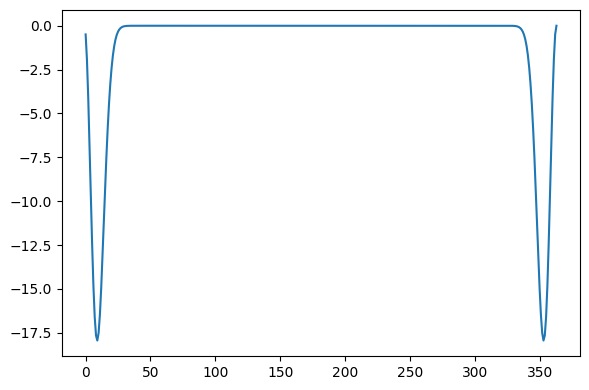

In [6]:
mexhat = net.mexhat
plt.figure(figsize = (6,4))
plt.plot(mexhat)
plt.tight_layout()
plt.show()

## Landmark input profile

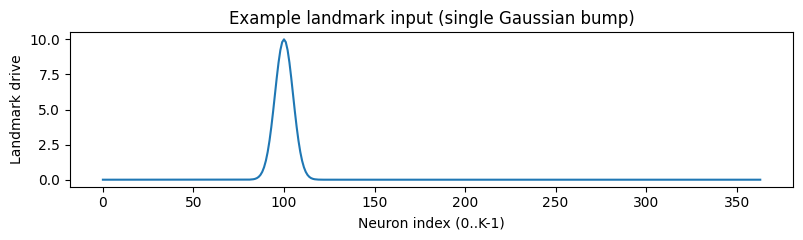

In [7]:
lm = sim.bump_for_initialization(lm_center = 100, lm_std=5.0, lm_gain=10.0)

plt.figure(figsize=(8,2.5))
plt.plot(np.arange(K), lm)
plt.title("Example landmark input (single Gaussian bump)")
plt.xlabel("Neuron index (0..K-1)")
plt.ylabel("Landmark drive")
plt.tight_layout()
plt.show()

## Initialization to a stable pattern
Run $\text{init\_state}()$ to verify it leads to a periodic activity, and multiple peaks exist and are stable

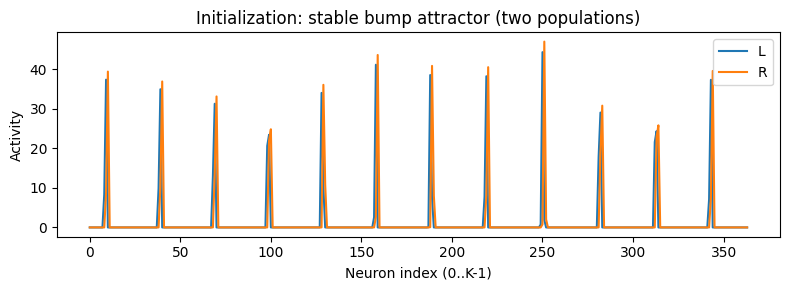

Peak idx L: 250 Peak idx R: 251


In [8]:
init = sim.init_state(T=10)

plt.figure(figsize=(8,3))
plt.plot(np.arange(K), init[:K], label="L")
plt.plot(np.arange(K), init[K:], label="R")
plt.title("Initialization: stable bump attractor (two populations)")
plt.xlabel("Neuron index (0..K-1)")
plt.ylabel("Activity")
plt.legend()
plt.tight_layout()
plt.show()

print("Peak idx L:", int(np.argmax(init[:K])), "Peak idx R:", int(np.argmax(init[K:])))


Verify periodicity and stability: peaks are quite close in value and are approximarely 30 neurons away from each other

In [9]:
def find_n_peaks(s, n):
    d = {}
    ring = s.copy()
    for i in range(n):
        peak_idx = np.argmax(ring)
        #print(peak_idx, s[peak_idx])
        d[peak_idx] = ring[peak_idx]
        ring[peak_idx] = 0
    
    return d


In [10]:
s_L = init[:K].copy()
peaks = find_n_peaks(s_L, 12)
p = sorted(peaks.keys())
[np.abs(p[i]-p[i+1]) for i in range(0, 11)]

[np.int64(30),
 np.int64(30),
 np.int64(30),
 np.int64(29),
 np.int64(30),
 np.int64(30),
 np.int64(31),
 np.int64(31),
 np.int64(32),
 np.int64(31),
 np.int64(30)]

In [11]:
sorted(peaks)

[np.int64(9),
 np.int64(39),
 np.int64(69),
 np.int64(99),
 np.int64(128),
 np.int64(158),
 np.int64(188),
 np.int64(219),
 np.int64(250),
 np.int64(282),
 np.int64(313),
 np.int64(343)]

## Trial simulation

In [12]:
trial = sim.run_trial(init_condition = init)

In [13]:
trial

{'s': array([[8.99095350e-110, 8.87856658e-110, 8.76758449e-110, ...,
         1.84893844e-032, 1.82582671e-032, 1.80300388e-032],
        [1.47506910e-109, 1.45663074e-109, 1.43842285e-109, ...,
         1.57588205e-031, 1.55618353e-031, 1.53673123e-031],
        [9.63666696e-109, 9.51620862e-109, 9.39725601e-109, ...,
         1.34239741e-030, 1.32561744e-030, 1.30904722e-030],
        ...,
        [7.28454677e-110, 7.19348993e-110, 7.10357131e-110, ...,
         3.22268814e+001, 3.25123029e+001, 3.27974011e+001],
        [7.28454677e-110, 7.19348993e-110, 7.10357131e-110, ...,
         7.70609841e-035, 7.60977218e-035, 7.51465003e-035],
        [7.28454677e-110, 7.19348993e-110, 7.10357131e-110, ...,
         6.57937716e-034, 6.49713494e-034, 6.41592076e-034]],
       shape=(728, 65236)),
 'nn_state': array([ 30,  39,  39, ..., 359, 359, 360], shape=(65236,)),
 'lm_amplitude': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.29568149e-11, 1.28912156e-11, 1.28259

In [14]:
print(trial['s'].shape)
trial['nn_state'].shape

(728, 65236)


(65236,)

## Wrapped case

$\text{trial}[\text{"nn\_state"}]$ is the wrapped index $0, \dots, K-1$ of *which peak* we are tracking on the ring

We try tracking a discrete peak of a periodic spatial pattern that is translating

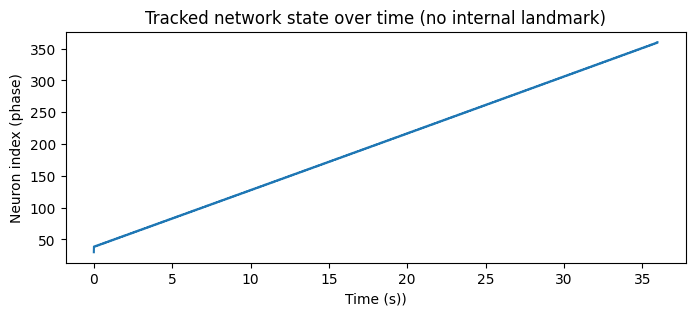

In [15]:
trial_nolm = sim.run_trial(
    init_condition = init, landmarkpresent=False,
    #
    )
plt.figure(figsize=(8,3))
plt.plot(np.arange(len(trial_nolm['nn_state'])) * net.dt, trial_nolm['nn_state'], label="L")
nr_steps = trial_nolm.get('s').shape[1]

plt.xlabel("Time (s))")
plt.ylabel("Neuron index (phase)")
plt.title("Tracked network state over time (no internal landmark)")
plt.show()

Without landmarks, the CAN supports a translating periodic activity pattern whose phase advances continuously under velocity input. Noise and discretization cause small trial-to-trial variability, producing a thick diagonal band when plotting wrapped peak indices.

Here we observe the position of the 'next peak ahead' sampled at discrete time steps, which already implies discretization (quantization) and small variability even in constant velocity.

The periodic pattern is not perfectly rigid, as peak heights fluctuate, spacing is not perfctly uniform.

Local interactions and nonlinearity may distort the pattern and sometimes it may happen that a peak is detected slightly earlier or later, or there is some ambiguity between two consecutive peaks. It looks like a thick band, and even with perfectly constant velocity, the time at which we cross a peak depend on noise and amplitude, so peak transitions do not occur exactly at the same step. The slope is given by the noise term of the velocity. 

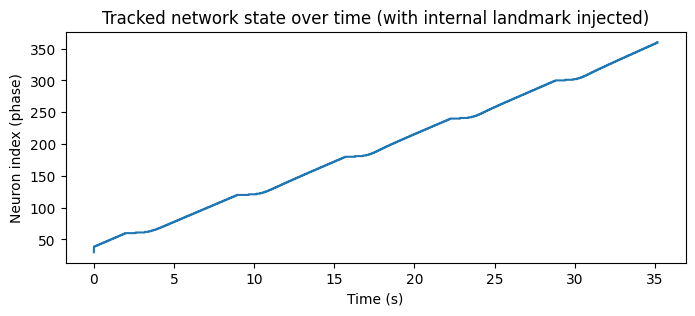

In [16]:
trial_lm = sim.run_trial(init_condition = init, landmark_input_loc=(60, 120, 180, 240, 300))
plt.figure(figsize=(8,3))
plt.plot(np.arange(len(trial_lm['nn_state'])) * net.dt, trial_lm['nn_state'], label="L")
plt.xlabel("Time (s)")
plt.ylabel("Neuron index (phase)")
plt.title("Tracked network state over time (with internal landmark injected)")
plt.show()

A flat region orr with very shallow slope represents time steps where the translation of the pattern has slowed down or almost stopped.

We can qualitatively see that, since only the LM condition shows flat regions, landmark injection is likely the cause of this behavior.

We interpret this with the intuition that with internal landmarks, transient excitatory inputs injected at specific phases stabilize the pattern and transiently suppress translation, producing plateaus in the unwrapped phase trajectory. These plateaus correspond to endogenous landmark “resets” and lead to reduced accumulation of variability over time.

In this plot, a region can stay flat either because the phase is not changing much, or because there is an almost complete *wrap* around the cycle. In this wrapped-up case it is not easy to disambiguate this.

We can inspect velocity gains and ladmark amplitude during flat areas.
During flat regions with landmarks we expect:
- high landmark amplitude
- velocity drive suppressed by external input
- translation stalls

In [17]:
trial_lm

{'s': array([[8.64924841e-110, 8.54113280e-110, 8.43436864e-110, ...,
         3.14327653e-034, 3.10398557e-034, 3.06518575e-034],
        [1.25546481e-109, 1.23977150e-109, 1.22427435e-109, ...,
         3.40580068e-033, 3.36322817e-033, 3.32118782e-033],
        [5.71845212e-109, 5.64697147e-109, 5.57638433e-109, ...,
         3.68818234e-032, 3.64208007e-032, 3.59655406e-032],
        ...,
        [7.14197207e-110, 7.05269742e-110, 6.96453870e-110, ...,
         3.20086530e+001, 3.22667052e+001, 3.25244817e+001],
        [7.14197207e-110, 7.05269742e-110, 6.96453870e-110, ...,
         5.71310490e-037, 5.64169109e-037, 5.57116995e-037],
        [7.14197207e-110, 7.05269742e-110, 6.96453870e-110, ...,
         6.20226348e-036, 6.12473519e-036, 6.04817600e-036]],
       shape=(728, 72016)),
 'nn_state': array([ 30,  33,  33, ..., 359, 359, 360], shape=(72016,)),
 'lm_amplitude': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.27785596e-14, 7.23785881e-14, 7.19807

In [18]:
#np.arange(len(trial["phase_unw"])) * net.dt

## Track single trial + landmark amplitude

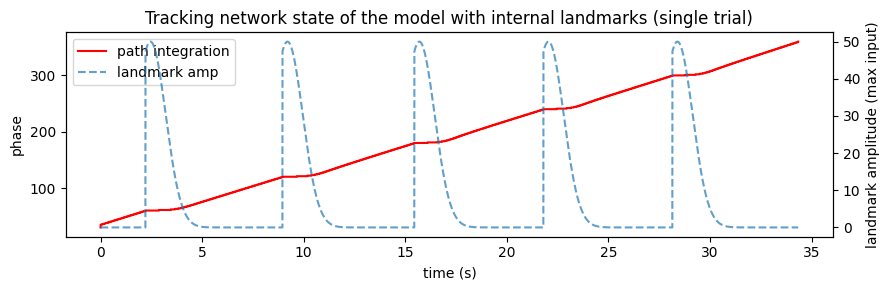

In [17]:
K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)


trial = sim.run_trial(init_condition=init, landmarkpresent=True, wm=0.05,# landmark_onset_steps = 200, landmark_tau_steps = 500
                      )

t = np.arange(len(trial["nn_state"])) * net.dt


fig, ax1 = plt.subplots(figsize=(9,3))

ax1.plot(t, trial["nn_state"], label="path integration", color = 'red')
ax1.set_xlabel("time (s)")
ax1.set_ylabel("phase")

ax2 = ax1.twinx()
ax2.plot(t, trial["lm_amplitude"], linestyle="--", label="landmark amp", alpha = 0.7)
ax2.set_ylabel("landmark amplitude (max input)")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc="upper left")
plt.title('Tracking network state of the model with internal landmarks (single trial)')
plt.tight_layout()
plt.show()

if landmarks are effectively doing anything, then we expect to see a plateau where the landmark amplitude reaches its peak

--> the endogenous landmarks should act as resets / anchors, transiently arresting the movement

### Final simulator structure:

- $\text{init\_state}$:
    static landmark bump (normalized) + tiny velocity noise

- $\text{run\_trial}$:
    - constant noisy velocity per trial
    - internal landmark input is a comb at all centers ($\text{lm\_locs} + 3$), gated by which region you’re in and an amplitude Gaussian in time since region entry
    - peak tracking: “tail window then first peak”

# Simulate Fig 4.c
Fig 4.c represents the trajectories of the evolution of the network state in time, for a model without internal landmarks (black) and a model with endogenous landmarks (red)

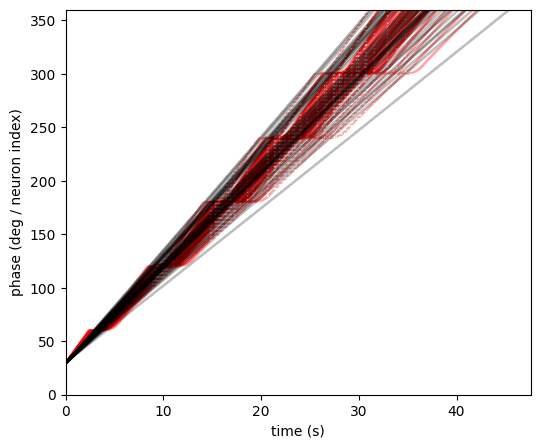

In [41]:
num_sim = 50
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360

wm = 0.08
wolm_speed = 0.35
wlm_speed  = 0.42

fig, ax = plt.subplots(figsize=(6, 5))

# WITH internal landmarks (red)
for _ in range(num_sim):
    out = sim.run_trial(init_condition=init,
                        initial_phase=initial_phase,
                        end_phase=end_phase,
                        landmarkpresent=True,
                        landmark_input_loc=lm_locs,
                        wolm_speed=wolm_speed,
                        wlm_speed=wlm_speed,
                        wm=wm)

    t = np.arange(len(out["phase_unw"])) * net.dt
    ax.plot(t, out["phase_unw"], alpha=0.35, color = 'red')

    # dotted reset lines (peak of LM envelope)
    lm_entry = out.get("lm_entry_times", None)
    if lm_entry is not None:
        reset_steps = lm_entry + 500  # landmark_onset_steps default=500
        reset_steps = reset_steps[~np.isnan(reset_steps)].astype(int)
        for rs in reset_steps:
            ax.axvline(rs * net.dt, linestyle=":", linewidth=1, color = 'white')

# WITHOUT landmarks (black)
for _ in range(num_sim):
    out = sim.run_trial(init_condition=init,
                        initial_phase=initial_phase,
                        end_phase=end_phase,
                        landmarkpresent=False,
                        landmark_input_loc=lm_locs,
                        wolm_speed=wolm_speed,
                        wlm_speed=wlm_speed,
                        wm=wm)
    t = np.arange(len(out["phase_unw"])) * net.dt
    ax.plot(t, out["phase_unw"], alpha=0.25, color = 'black')

ax.set_xlabel("time (s)")
ax.set_ylabel("phase (deg / neuron index)")
#ax.set_xlim(0, 4)
ax.set_xlim(left = 0)
ax.set_ylim(0, 360)
plt.show()

Note that the behavior seems to match the result of fig 4.c, since there exists some periodic 'plateau' acting as a reset when stored internal landmarks are present and are injected in the network.

However, with the current parameters taken as a baseline from NFJ24, the network takes approximately $4s$ to reach a landmark, while in the real task landmarks are shown with a periodicity of $0.65s$. The time needed to hit each of the landmarks depends on the drift speed and, if it lower, the path integration is going to be slower too.

So the next step is to do a grid search over velocities, as the authors of the paper did in their research, to tune $\text{wolm}_\text{speed}$ and $\text{wlm}$

In [ ]:
def plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    landmark_input_loc,
    wolm_speed, wlm_speed, wm,
    scale = None,
    title:str = None
):
    fig, ax = plt.subplots(figsize=(6, 5))

    # WITHOUT landmarks (black)
    for _ in range(num_sim):
        out = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=False,
                            landmark_input_loc=landmark_input_loc,
                            wolm_speed=wolm_speed,
                            wlm_speed=wlm_speed,
                            wm=wm)
        t_sim = np.arange(len(out["nn_state"])) * net.dt
        if scale:
            t = t_sim * scale
        else:
            t = t_sim
        ax.plot(t, out["nn_state"], alpha=0.25, color = 'black')
    
    # WITH internal landmarks (red)
    reset_times_all = []
    for _ in range(num_sim):
        out = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=True,
                            landmark_input_loc=landmark_input_loc,
                            wolm_speed=wolm_speed,
                            wlm_speed=wlm_speed,
                            wm=wm,
                            #landmark_onset_steps = 200,
                            #landmark_tau_steps = 150)
        )
        t_sim = np.arange(len(out["nn_state"])) * net.dt
        if scale:
            t = t_sim * scale
        else:
            t = t_sim
        ax.plot(t, out["nn_state"], alpha=0.25, color="red")


    for y in landmark_input_loc:
        ax.axhline(y, linestyle="--", linewidth=1, color="white", alpha = 1.0)

    ax.set_xlabel("time (s)")
    ax.set_ylabel("phase (deg / neuron index)")
    ax.set_xlim(left=0)
    ax.set_ylim(0, 360)
    if scale:
        plt.xticks([0.65, 1.3, 1.95, 2.6, 3.25])
    if title:
        os.makedirs('Fig_CAN', exist_ok=True)
        plt.savefig(f'Fig_CAN/Fig_4c_{title}.png', dpi=300, bbox_inches="tight")
    plt.show()


    

'\n\n    t = np.arange(len(out["phase_unw"])) * net.dt\n        ax.plot(t, out["phase_unw"], alpha=0.35, color = \'red\')\n\n        # dotted reset lines (peak of LM envelope)\n        lm_entry = out.get("lm_entry_times", None)\n        if lm_entry is not None:\n            reset_steps = lm_entry + 500  # landmark_onset_steps default=500\n            reset_steps = reset_steps[~np.isnan(reset_steps)].astype(int)\n            for rs in reset_steps:\n                ax.axvline(rs * net.dt, linestyle=":", linewidth=1, color = \'white\')\n\n    ax.set_xlabel("time (s)")\n    ax.set_ylabel("phase (deg / neuron index)")\n    #ax.set_xlim(0, 4)\n    ax.set_xlim(left = 0)\n    ax.set_ylim(0, 360)\n    plt.show()\n'

## Run with different wm

In [25]:
num_sim = 50
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360

K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)

wm = 0.08

# Baseline 
wolm_speed = 0.35
wlm_speed  = 0.42

# try faster
# no landmark: v=0.45 -> T=27.126s
# with landmark: v=0.65 -> T=27.139s
wolm_speed = 0.45
wlm_speed = 0.65


trial_lm = sim.run_trial(init_condition=init,
                            initial_phase=initial_phase,
                            end_phase=end_phase,
                            landmarkpresent=True,
                            landmark_input_loc=lm_locs,
                            wolm_speed=wolm_speed,
                            wlm_speed=0.8,
                            wm=0.0)



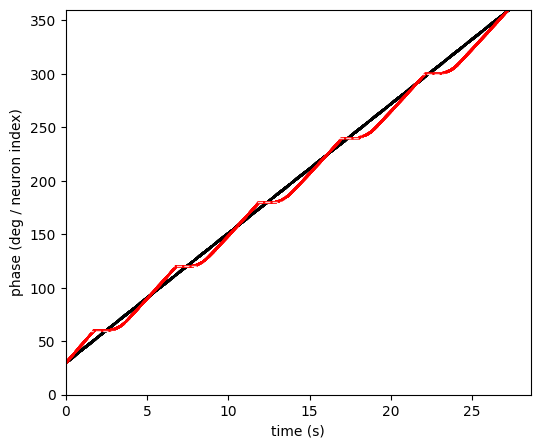

In [77]:
## wm= 0.0
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.0)

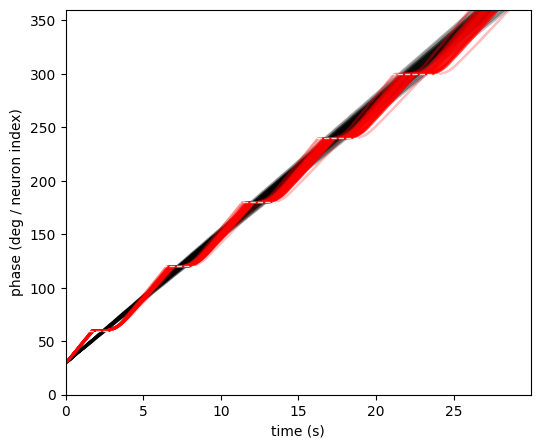

In [78]:
## wm= 0.02
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.02)

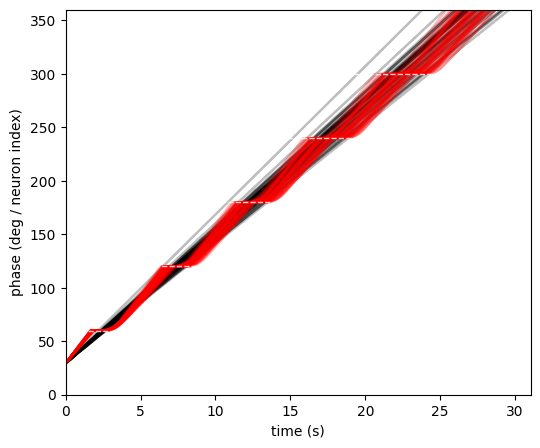

In [79]:
## wm= 0.05
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.05)

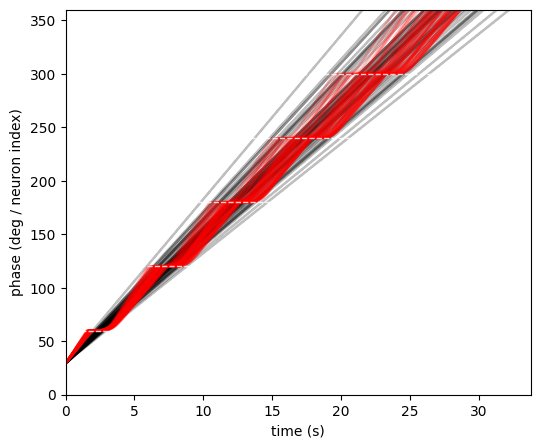

In [80]:
## wm= 0.08
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed, wlm_speed, wm = 0.08)

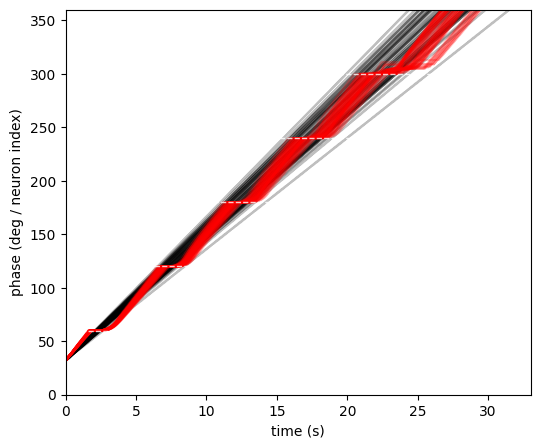

In [36]:
lm_locs = np.arange(60, 301, 60)  
initial_phase = 30
end_phase = 360
num_sim = 50

K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)

wolm_speed = 0.45
wlm_speed = 0.65


## beware of extreme case (glitch near wrap zone?)
plot_fig4c(
    net,
    sim,
    num_sim,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed = 0.45, wlm_speed = 0.6,
    #wolm_speed= 0.6, wlm_speed = 0.7,
    wm = 0.05)

## Tuning Fig 4.c with the correct temporal scale



### Re-Tune wlm_speed and wolm_speed
The CAN evolves in phase units (which culd be neurons around the ring or degrees, depending on the preference).

We have seen from plasticity that internal landmarks were learned to be periodic in phase; so, to compare to our behavior and the specific navigation task, we need that periodicity to show up every $0.65s$ in time.

Need to tune the two base speeds so that:
- without landmarks: mean time to reach $360$ is $\sim 3.9$ / $4.0$
- with landmarks: mean time is similar too

*Remark*\
We need to separately tune $v_\text{LM}$ and $v_{\text{noLM}}$ because landmarks transiently 'stop the network' (produce a reset in phase shift). During those arrest/reset moments, the network makes less progress per unit time.

So if we ran simulations using the same baseline velocity in both models (with and without landmarks), the landmark model would take longer on average to reach the same final phase.

This explains why the authors used a higher baseline velocity for the landmark model:
- $v_\text{LM} = 0.42$ a.u.
- $v_{\text{noLM}} = 0.35$ a.u.

note that these values are written as arbitrary units and cannot be intended as a precise measure of distance traveled per unit time.

#### wrt total time of the simulation
First, we verified that the behavior of path integration scaled monotonically with velocity:

In [19]:
def mean_T_to_end(
    sim,
    init,
    landmarkpresent,
    wm,
    wlm_speed,
    wolm_speed,
    initial_phase=30,
    end_phase=360,
    n=20):
    Ts = []
    for _ in range(n):
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=landmarkpresent,
            landmark_input_loc=np.arange(60, 301, 60),
            wlm_speed=wlm_speed,
            wolm_speed=wolm_speed,
            wm=wm
        )
        phase = out['nn_state']
        dphase = np.diff(phase)
        #print("max dphase:", dphase.max(), "min dphase:", dphase.min(), "any big jumps > 50?", np.any(dphase > 50))
        Ts.append((len(out["nn_state"]) -1) * sim.network.dt)
    return float(np.mean(Ts)), float(np.std(Ts))

def time_to_end(sim, init, v, wm, landmarkpresent, end_phase=360):
    out = sim.run_trial(init_condition=init, landmarkpresent=landmarkpresent, wm=0.0,
                        wolm_speed=v, wlm_speed=v, end_phase=end_phase, T_max=60,
                        landmark_onset_steps=200, landmark_tau_steps =150
    )
    return (len(out["nn_state"]) - 1) * sim.network.dt


In [20]:
vels = np.linspace(0.1, 0.95, 20)
Ts = []
print('No lm')
for v in vels:
    T = time_to_end(sim, init, v, 0.0, False)
    Ts.append(T)
    print(f"v={v:.2f} -> T={T:.3f}s")

No lm
v=0.10 -> T=60.000s
v=0.14 -> T=60.000s
v=0.19 -> T=60.000s
v=0.23 -> T=51.233s
v=0.28 -> T=42.995s
v=0.32 -> T=37.087s
v=0.37 -> T=32.639s
v=0.41 -> T=29.166s
v=0.46 -> T=26.374s
v=0.50 -> T=24.079s
v=0.55 -> T=22.160s
v=0.59 -> T=20.527s
v=0.64 -> T=19.123s
v=0.68 -> T=17.901s
v=0.73 -> T=16.828s
v=0.77 -> T=15.877s
v=0.82 -> T=16.427s
v=0.86 -> T=15.595s
v=0.91 -> T=14.845s
v=0.95 -> T=14.163s


In [21]:
vels = np.linspace(0.1, 0.95, 25)
Ts = []
print('lm')
for v in vels:
    T = time_to_end(sim, init, v, 0.0, True)
    Ts.append(T)
    print(f"v={v:.2f} -> T={T:.3f}s")

lm
v=0.10 -> T=60.000s
v=0.14 -> T=60.000s
v=0.17 -> T=60.000s
v=0.21 -> T=58.632s
v=0.24 -> T=50.044s
v=0.28 -> T=43.712s
v=0.31 -> T=38.849s
v=0.35 -> T=34.993s
v=0.38 -> T=31.858s
v=0.42 -> T=29.260s
v=0.45 -> T=27.071s
v=0.49 -> T=25.201s
v=0.53 -> T=23.584s
v=0.56 -> T=22.172s
v=0.60 -> T=20.928s
v=0.63 -> T=19.826s
v=0.67 -> T=18.840s
v=0.70 -> T=17.954s
v=0.74 -> T=17.151s
v=0.77 -> T=16.422s
v=0.81 -> T=17.158s
v=0.84 -> T=16.487s
v=0.88 -> T=21.064s
v=0.91 -> T=20.321s
v=0.95 -> T=20.791s


In the paper, 0.65 s is the task’s landmark spacing (“0.65 s between landmarks”), and the model is in **arbitrary units** (they even call velocity “a.u.”). They then choose velocity inputs to mean-match temporal distances and mark multiples of 0.65 s on the plots.

We observe that velocity input is inversely proportional to the total time taken to complete one trial through $5$ landmarks.

However, the model's internal scale does not match that implemented by the authors, but it appears to be $\sim 10$ times slower in simulation time.

Therefore, the only solution here is to match the task with a unit conversion (choosing how many 'model seconds' correspond to one 'task second'.) 

## Unit calibration

In these CAN simulations, $dt$ and $\tau_s$ are “simulation time units”; the mapping to the experiment’s $0.65 s$ base interval is done by calibrating a scale factor (or equivalently, “optimal velocity” in arbitrary units). The Methods explicitly describe a grid search to match $0.65 s$ periodicity / mean-matched distances.

Since, even after grid searching different combinations of velocities, landmark onset and offset step and discretization units, the time scale is still on a completely different scale than the one that has been plotted, that just means the current mapping from sim-time $\mapsto$ seconds is off by some scale factor:

- $\text{sim\_time} \sim 5s$
- $\text{target\_time} = 0.65s$

then:
- $\text{task\_time} = 0.65 \times \frac{\text{sim\_time}}{\text{sim\_time}} = \frac{0.65}{\text{sim\_time}} \times \text{sim\_time}$
- $\Longrightarrow \text{scale} =\frac{0.65}{\text{sim\_time}}$



### Procedure:
1. pick a reference mapping (scale) from model-time to seconds using the LM condition (because it is anchored by resets)
2. compute temporal distances
3. adjust no-LM velocity input to mean-match the temporal distances of the LM model

For this attempt, we keep:
- $\text{wlm\_speed} = 0.65$ (slightly faster than baseline $0.42$)
- $\text{wm} = 0.05$

### 1. Pick lm_speed and model->task time mapping

**Because the landmark input (Iint) transiently stops the velocity drive of the network, we scaled the velocity input such that the average time taken to reach a desired state is the same for the two models.**

From a reasonable lm_speed base velocity of $0.65$ and no noise, we compute the corresponding scale:

In [22]:
def lm_scale_from_interval(
        sim,
        init,
        landmark_locs,
        initial_phase,
        end_phase,
        wlm_speed,
        wm,
        n_trials
):
    net = sim.network
    landmarks = np.asarray(landmark_locs, dtype=float)
    intervals = []

    for _ in range(n_trials):
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=True,
            landmark_input_loc=landmarks,
            wlm_speed=wlm_speed,
            wm=wm,
        )
        nn = np.asarray(out["nn_state"])
        t_sim = np.arange(len(nn)) * net.dt

        cross_times = []
        for y in landmarks:
            idx = np.where(nn >= y)[0]
            cross_times.append(t_sim[idx[0]] if idx.size else np.nan)
        cross_times = np.asarray(cross_times, dtype=float)

        if np.any(np.isnan(cross_times)):
            continue

        intervals.append(np.mean(np.diff(cross_times)))

    intervals = np.asarray(intervals, dtype=float)
    sim_interval = float(np.mean(intervals))
    scale = 0.65 / sim_interval
    return scale


In [23]:
lm_locs = np.arange(60, 301, 60)  
initial_phase = 0
end_phase = 360
w_nolm = 0.45
w_lm = 0.65

for wm in [0.0, 0.02, 0.05, 0.08]:
    sim_mean_scale = lm_scale_from_interval(
        sim, init,
        lm_locs, initial_phase, end_phase,
        w_lm, wm=wm, n_trials = 20)
    print(f'scale with wm= {wm} ==>\t {sim_mean_scale}')

scale with wm= 0.0 ==>	 0.137148885665304
scale with wm= 0.02 ==>	 0.1366274563383316
scale with wm= 0.05 ==>	 0.13671276778942026
scale with wm= 0.08 ==>	 0.13360860131064897


Scale computed is quite similar across different values of noise

This means that with the internal module speed, the model takes $\sim4.7$ model time units to travel $60$ neuron phases, leading to a drift speed of $\sim 12$ phase units per model second.

To make it correspond to $0.65s$ in task time, we need a scale factor of $\sim \frac{0.65}{4.7} \simeq 0.137$

let's try to see if it scale correctly.

in this step, black lines is expected not to be perfectly aligned with the red ones, since we're interested in verifying whether the adopted scaled velocity is an optimal velocity and its timing is consistent with the periodicity of the task

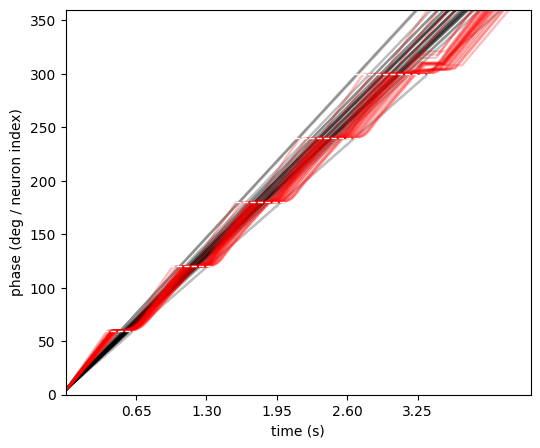

In [24]:
scale_05 = lm_scale_from_interval(sim, init, lm_locs,
                        initial_phase = 0, end_phase = 360,
                        wlm_speed = 0.65, wm=0.05, n_trials = 20)

plot_fig4c(
    net,
    sim,
    30,
    init, initial_phase, end_phase,
    lm_locs,
    wolm_speed = 0.5, wlm_speed = 0.65, wm = 0.05,
    scale = scale_05)

In [25]:
print(f'scale with noise 0.05: {scale_05}')

scale with noise 0.05: 0.13612583262543537


### 2. Compute target LM distance at task times

**Under the optimal velocity, we found the distance traversed (in terms of phase state) by the network with landmarks in 0.65 s and its multiples.**

In this step, we implement a method to compute the mean distances at each landmark location times (multiples of $0.65 s$) in the LM model

Here, we apply the reverse mapping from $\text{task\_time}$ to $\text{model\_time}$: 
- $\text{model\_time} = \frac{\text{task\_time}}{\text{scale}}$

- then $\text{model\_idx} = \frac{\text{time (model)}}{dt}$



In [26]:
def mean_dist_from_times(
    sim, init,
    wlm_speed: float, wolm_speed: float, wm: float,
    scale: float,
    task_times = (0.65, 1.30, 1.95, 2.60, 3.25),
    n_trials: int = 50,
    initial_phase: float = 0,
    end_phase: float = 360,
    landmark_locs = (60,120,180,240,300),
    landmarkpresent = True
):
    """
    Run LM trials and compute mean distance (nn_state) at given task times.
    Uses t_model = t_task / scale.
    """
    net = sim.network
    task_times = np.asarray(task_times, dtype=float)
    landmark_locs = np.asarray(landmark_locs, dtype=float)

    model_times = task_times / scale
    model_idxs = np.round(model_times / net.dt).astype(int)

    dists = np.full((n_trials, len(task_times)), np.nan, dtype=float)

    for i in range(n_trials):
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=landmarkpresent,
            landmark_input_loc=landmark_locs,
            wlm_speed=wlm_speed,
            wm=wm,
        )
        nn = np.asarray(out["nn_state"])
        for j, idx in enumerate(model_idxs):
            if idx < len(nn):
                dists[i, j] = float(nn[idx])

    mean = np.nanmean(dists, axis=0)
    std = np.nanstd(dists, axis=0, ddof=1)
    n_eff = np.sum(~np.isnan(dists), axis=0)
    sem = std / np.sqrt(np.maximum(n_eff, 1))

    return {
        "task_times": task_times,
        "model_times": model_times,
        "model_idxs": model_idxs,
        "dists": dists,
        "mean_dist": mean,
        "sem": sem,
        "n_eff": n_eff,
    }

In [27]:
lm_stats = mean_dist_from_times(
    sim, init, 
    wlm_speed = 0.65,
    wolm_speed = 0.5,
    wm = 0.05,
    scale = scale_05,
    n_trials= 30,
    initial_phase = 0, end_phase = 360,
    landmarkpresent= True
)

print("scale:", scale_05)
print("LM mean distances at task times:")
for t, d, s in zip(lm_stats["task_times"], lm_stats["mean_dist"], lm_stats["sem"]):
    print(f"  t={t:>4.2f}s -> dist={d:>7.2f} ± {s:>6.2f}")

scale: 0.13612583262543537
LM mean distances at task times:
  t=0.65s -> dist=  64.27 ±   0.32
  t=1.30s -> dist= 123.97 ±   0.73
  t=1.95s -> dist= 186.20 ±   1.20
  t=2.60s -> dist= 248.47 ±   1.65
  t=3.25s -> dist= 310.13 ±   2.07


This returns the average distances $d_k$ (neuron indices) traveled by the LM model to reach landmark locations at times $t_k = k\cdot 0.65$

### 3. Grid Search wolm_speed to match time taken to reach landmark locations in LM model

**We then did a second grid search in the model without landmarks to identify appropriate velocity inputs such that, on average, the model takes the same duration to reach the corresponding distances.**

first i check if the previous method prints something for the no-LM case too: (ofc it isn't matching yet)

In [173]:
nolm_stats = mean_dist_from_times(
    sim, init, 
    wlm_speed = 0.65,
    wolm_speed = 0.5,
    wm = 0.05,
    scale = scale_05,
    n_trials= 50,
    initial_phase = 0, end_phase = 360,
    landmarkpresent= False
)

print("scale:", scale_05)
print(f"no-LM mean distances at task times for {wolm_speed=}:")
for t, d, s in zip(nolm_stats["task_times"], nolm_stats["mean_dist"], nolm_stats["sem"]):
    print(f"  t={t:>4.2f}s -> dist={d:>7.2f} ± {s:>6.2f}")

scale: 0.1367710203249627
no-LM mean distances at task times for wolm_speed=0.45:
  t=0.65s -> dist=  48.42 ±   0.35
  t=1.30s -> dist=  94.02 ±   0.68
  t=1.95s -> dist= 139.60 ±   1.02
  t=2.60s -> dist= 185.20 ±   1.35
  t=3.25s -> dist= 230.82 ±   1.70


In [177]:
nolm_stats.get('mean_dist')

array([ 48.42,  94.02, 139.6 , 185.2 , 230.82])

So what we do now:
- LM gives target distances $d_k$, each reached at task time $t_k = k \cdot 0.65$
- For each $k$, choose a separate $\text{wolm\_speed}$ such that the No-LM mean time to reach $d_k$ equals $t_k$

So we need to match: $\mathbb{E}[T_{\text{NoLM}}(d_k)] \simeq t_k$

We first need a function for the No-LM model that, given a distance threshold $d$, computes mean model time to first cross it across trials, then converts to task time via $\text{scale}$

In [28]:
def mean_time_to_reach_d(
        sim, init,
        wlm_speed:float, wolm_speed:float, wm:float,
        scale:float,
        d,
        n_trials:int = 20,
        initial_phase = 0,
        end_phase = 360,
        landmarkpresent = False
):
    dt = sim.network.dt
    times_model = np.full(n_trials, np.nan, dtype=float)

    for i in range(n_trials):
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=landmarkpresent,
            wolm_speed=wolm_speed,
            wlm_speed = wlm_speed,
            wm=wm
        )
        nn = np.asarray(out["nn_state"], dtype=float)
        idx = np.where(nn >= d)[0]
        times_model[i] = np.nan if idx.size == 0 else float(idx[0] * dt)
    
    mean_model = float(np.nanmean(times_model))
    sem_model = float(np.nanstd(times_model, ddof=1) / np.sqrt(np.sum(~np.isnan(times_model))))

    mean_task = mean_model * scale
    sem_task = sem_model * scale

    return {
        "distance": float(d),
        "times_model": times_model,
        "mean_model": mean_model,
        "sem_model": sem_model,
        "mean_task": mean_task,
        "sem_task": sem_task,
        "n_eff": int(np.sum(~np.isnan(times_model))),
    }

Now we do the grid search in the model without landmarks to identify appropriate velocity inputs such that, on average, the model takes the same duration
to reach the corresponding distances.

The authors performed the following search five times independently for the five temporal distances.

In [29]:
def grid_search_wolm_avgtime(
        sim, init,
        distance,
        wolm_grid,
        wlm_speed,
        wm:float,
        scale:float,
        target_task_time: np.ndarray,
        n_trials: int = 20,
        initial_phase = 0,
        end_phase = 360
        ):
    """
    Given one distance index, search of wolm_speed that reaches it with the most similar task time to the one given 
    """
    best = None
    history = []
    
    for v in wolm_grid:
        stats = mean_time_to_reach_d(
            sim= sim,
            init= init,
            wlm_speed = wlm_speed, # landmark= false, so not considered
            wolm_speed = v,
            wm= wm,
            scale = scale,
            d = distance,
            n_trials = n_trials,
            initial_phase = initial_phase,
            end_phase = end_phase,
            landmarkpresent=False)
        err = (stats['mean_task'] - target_task_time)**2
        history.append((float(v), float(stats['mean_task']), float(err)))

        if best is None or err < best['err']:
            best = {
                'wolm_speed': float(v),
                'mean_task': float(stats['mean_task']),
                'err': float(err),
                'n_eff': stats['n_eff']
                }
    return {"best": best, "history": history}

In [30]:
def independent_search_wolm_speed(
        sim, init,
        mean_lm_dists: np.ndarray,
        wolm_grid,
        wlm_speed, wm:float,
        scale,
        target_task_times = np.array([0.65, 1.30, 1.95, 2.60, 3.25]),
        n_trials = 20,
):
    """
    Given the 5 LM model target distances, for each of them:
        - compute the wolm velocity making the noLM model reach the dist in the corresponding task time
    Returns:
        - 5 wolm_speed[k] velocities, one for each landmark location
    """

    lm_mean_dists = np.asarray(mean_lm_dists, dtype = float)
    task_times = np.asarray(target_task_times, dtype= float)

    matching_vels = []
    for k in range(len(task_times)):
        d_k = float(lm_mean_dists[k])
        t_k = float(task_times[k])

        res = grid_search_wolm_avgtime(
            sim=sim, init=init,
            distance= d_k,
            wolm_grid = wolm_grid,
            wlm_speed = wlm_speed, wm=wm,
            scale=scale,
            target_task_time= t_k,
            n_trials = n_trials
        )
        matching_vels.append({
            "task_time": t_k,
            "lm_target_distance": d_k,
            "best_wolm": res["best"]["wolm_speed"],
            "best_mean_time": res["best"]["mean_task"],
            "best_err": res["best"]["err"],
            "history": res["history"],
            }
        )
    return matching_vels
        

In [31]:
lm_stats['mean_dist']

array([ 64.26666667, 123.96666667, 186.2       , 248.46666667,
       310.13333333])

### parenthesis: try with wlm_speed = 0.65

In [186]:
print("Best wolm_speed:", grid_result["best"]["wolm_speed"], "\twith error:", grid_result["best"]["err"])
print("No-LM mean distances:", grid_result["best"]["nolm_mean"])
print("LM target distances:", lm_stats['mean_dist'])

Best wolm_speed: 0.5358974358974359 	with error: 11924.651899999999
No-LM mean distances: [ 48.35  93.85 139.4  184.8  230.25]
LM target distances: [ 62.44 121.62 182.62 243.88 305.06]


then, with this optimal wolm_speed, let's plot fig 4c

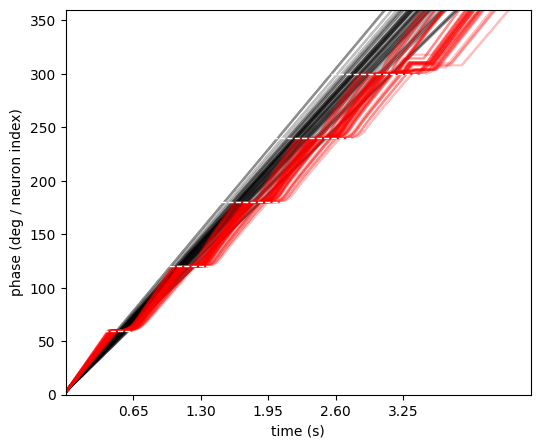

In [ ]:
plot_fig4c(
    net,
    sim,
    num_sim = 50,
    init = init, initial_phase= 0, end_phase = 360,
    landmark_input_loc= lm_locs,
    wolm_speed = grid_result['best']['wolm_speed'], wlm_speed = 0.65,
    #wolm_speed= 0.6, wlm_speed = 0.7,
    wm = 0.05,
    scale=scale_05)

# Simulate for baseline wlm_speed and all noise levels:

In [32]:
lm_locs = np.arange(60, 301, 60)  
initial_phase = 0
end_phase = 360
num_sim = 50

K = 364
net = CANNetwork(K = K)
sim = CANSimulator(net)
init = sim.init_state(T=10)

wolm_speed = 0.3
wlm_speed = 0.42

In [33]:
scales = {
    'scale_02': lm_scale_from_interval(sim, init, lm_locs, initial_phase, end_phase,
                                       wlm_speed, wm=0.02, n_trials = 20
    ),
    'scale_05': lm_scale_from_interval(sim, init, lm_locs, initial_phase, end_phase,
                                       wlm_speed, wm=0.05, n_trials = 20
    ),
    'scale_08': lm_scale_from_interval(sim, init, lm_locs, initial_phase, end_phase,
                                       wlm_speed, wm=0.08, n_trials = 20
    )
}
print(scales)

{'scale_02': 0.10001865732646281, 'scale_05': 0.09990768145972807, 'scale_08': 0.09961380494084472}


In [34]:
lm_mean_dists = {
    'mdist_02': mean_dist_from_times(sim, init, wlm_speed, wolm_speed,
                                     wm = 0.02,
                                     scale = scales.get('scale_02'),
                                     n_trials= 20,
                                     initial_phase = 0, end_phase = 360,
                                     landmarkpresent= True
    ),
    'mdist_05': mean_dist_from_times(sim, init, wlm_speed, wolm_speed,
                                     wm = 0.05,
                                     scale = scales.get('scale_05'),
                                     n_trials= 20,
                                     initial_phase = 0, end_phase = 360,
                                     landmarkpresent= True
    ),
    'mdist_08': mean_dist_from_times(sim, init, wlm_speed, wolm_speed,
                                     wm = 0.08,
                                     scale = scales.get('scale_08'),
                                     n_trials= 20,
                                     initial_phase = 0, end_phase = 360,
                                     landmarkpresent= True
    ),
}

In [35]:
for x in lm_mean_dists.keys():
    print(f'mean dists of LM model: {x}: {lm_mean_dists[x].get('mean_dist')}')

mean dists of LM model: mdist_02: [ 63.1  121.95 182.6  243.55 305.1 ]
mean dists of LM model: mdist_05: [ 63.35 122.8  184.45 246.3  308.25]
mean dists of LM model: mdist_08: [ 63.65 124.   185.95 248.15 310.5 ]


In [36]:
lm_mean_dists['mdist_02']

{'task_times': array([0.65, 1.3 , 1.95, 2.6 , 3.25]),
 'model_times': array([ 6.4987875, 12.997575 , 19.4963625, 25.99515  , 32.4939375]),
 'model_idxs': array([12998, 25995, 38993, 51990, 64988]),
 'dists': array([[ 64., 124., 187., 251., 315.],
        [ 63., 121., 182., 242., 303.],
        [ 63., 121., 181., 241., 302.],
        [ 64., 124., 186., 249., 312.],
        [ 64., 123., 185., 247., 311.],
        [ 63., 121., 182., 242., 303.],
        [ 62., 121., 181., 240., 300.],
        [ 62., 121., 181., 241., 301.],
        [ 62., 121., 181., 241., 301.],
        [ 64., 123., 184., 245., 308.],
        [ 63., 122., 182., 243., 304.],
        [ 63., 122., 182., 243., 304.],
        [ 63., 121., 181., 241., 302.],
        [ 62., 121., 181., 241., 301.],
        [ 63., 122., 182., 243., 304.],
        [ 64., 123., 184., 246., 309.],
        [ 64., 123., 184., 246., 309.],
        [ 63., 122., 183., 245., 307.],
        [ 63., 121., 181., 241., 302.],
        [ 63., 122., 182., 243., 

In [48]:
wolm_speed_grid = np.linspace(0.30, 0.40, 11)
wolm_try = {
    'wolm_02': independent_search_wolm_speed(sim, init,
                                             mean_lm_dists = lm_mean_dists['mdist_02'].get('mean_dist'),
                                             wolm_grid = wolm_speed_grid,
                                             wlm_speed = wlm_speed,
                                             wm= 0.02,
                                             scale = scales.get('scale_02'),
                                             n_trials = 3
                                            ),
    'wolm_05': independent_search_wolm_speed(sim, init,
                                             mean_lm_dists = lm_mean_dists['mdist_05'].get('mean_dist'),
                                             wolm_grid = wolm_speed_grid,
                                             wlm_speed = wlm_speed,
                                             wm= 0.05,
                                             scale = scales.get('scale_05'),
                                             n_trials = 3
                                            ),
    'wolm_08': independent_search_wolm_speed(sim, init,
                                             mean_lm_dists = lm_mean_dists['mdist_08'].get('mean_dist'),
                                             wolm_grid = wolm_speed_grid,
                                             wlm_speed = wlm_speed,
                                             wm= 0.08,
                                             scale = scales.get('scale_08'),
                                             n_trials = 3
                                            ),
}
wolm_02_try = [d["best_wolm"] for d in wolm_try["wolm_02"]]
wolm_05_try = [d["best_wolm"] for d in wolm_try["wolm_05"]]
wolm_08_try = [d["best_wolm"] for d in wolm_try["wolm_08"]]

In [51]:
wolm_02 = wolm_02_try.copy()
wolm_05 = wolm_05_try.copy()
wolm_08 = wolm_08_try.copy()

In [75]:
print(f'{wolm_02=}')
print(f'{wolm_05=}')
print(f'{wolm_08=}')

np.max(wolm_02)

wolm_02=[0.34, 0.33, 0.34, 0.34, 0.33]
wolm_05=[0.35, 0.34, 0.35, 0.34, 0.35]
wolm_08=[0.33, 0.36, 0.32, 0.34, 0.33]


np.float64(0.34)

To plot the figures, we use one representative per Weber noise (I choose the velocity computed for $k=1$, so for the first endogenous landmark)

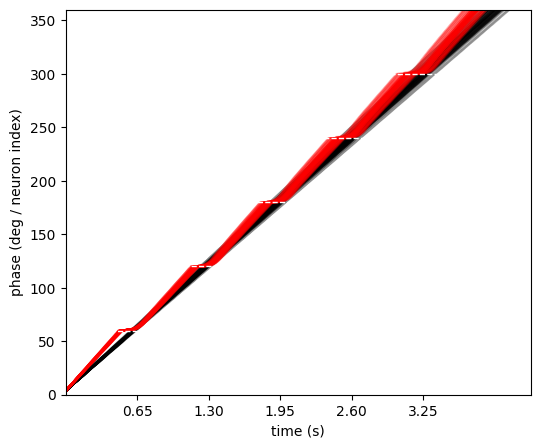

In [56]:
# wm= 0.02
plot_fig4c(
    net,
    sim,
    num_sim = 50,
    init = init, initial_phase= 0, end_phase = 360,
    landmark_input_loc= lm_locs,
    wolm_speed = np.max(wolm_02),
    wlm_speed = wlm_speed,
    wm = 0.02,
    scale= scales.get('scale_02'),
    title = 'wm_02'
)

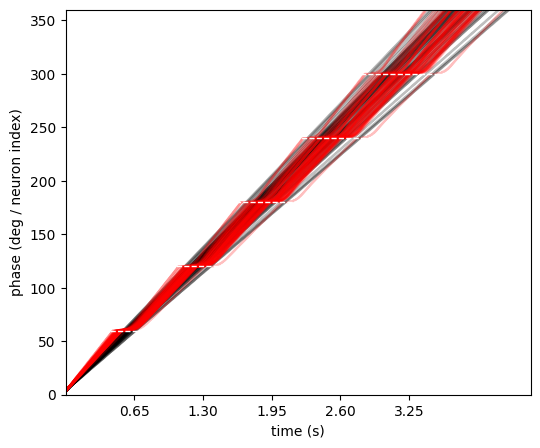

In [57]:
# wm= 0.05
plot_fig4c(
    net,
    sim,
    num_sim = 50,
    init = init, initial_phase= 0, end_phase = 360,
    landmark_input_loc= lm_locs,
    wolm_speed = np.max(wolm_05),
    wlm_speed = wlm_speed,
    wm = 0.05,
    scale= scales.get('scale_05'),
    title = 'wm_05'
)

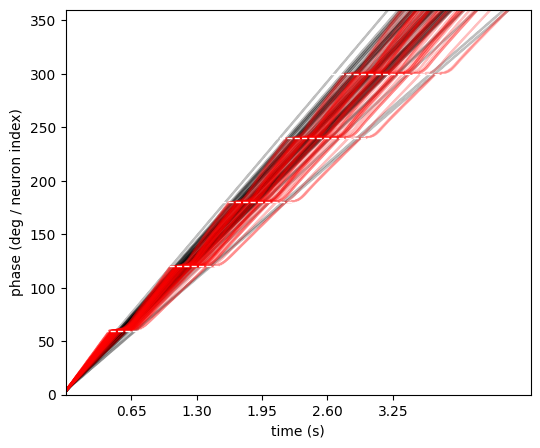

In [58]:
# wm= 0.08
plot_fig4c(
    net,
    sim,
    num_sim = 50,
    init = init, initial_phase= 0, end_phase = 360,
    landmark_input_loc= lm_locs,
    wolm_speed = np.max(wolm_08),
    wlm_speed = wlm_speed,
    wm = 0.08,
    scale= scales.get('scale_08'),
    title = 'wm_08'
)

In [95]:
scales['scale_02'], scales['scale_05'], scales['scale_08']

(0.10001865732646281, 0.09990768145972807, 0.09961380494084472)

In [ ]:
wolm_02=[0.34, 0.33, 0.34, 0.34, 0.33]
wolm_05=[0.35, 0.34, 0.35, 0.34, 0.35]
wolm_08=[0.33, 0.36, 0.32, 0.34, 0.33]

# mean dist / scale
mean_dist_02 = np.array([63.1 , 121.95, 182.6 , 243.55, 305.1])
mean_dist_05 = np.array([63.35, 122.8 , 184.45, 246.3 , 308.25])
mean_dist_08 = np.array([63.65, 124.  , 185.95, 248.15, 310.5 ])

## 1. How s.d. grows with temporal distance

### 1. Array of Task Times to reach a distance for several trials

In [59]:
# mean LM dists: lm_mean_dists['mdist_{wm}'].get('mean_dist')

## TIME TO REACH A DISTANCE

def task_times_to_reach_distance(
    sim, init,
    distance: float,
    landmarkpresent: bool,
    speed: float,           # wlm_speed if LM, wolm_speed if NoLM
    wm: float,
    scale: float,
    n_trials: int = 50,
    initial_phase: float = 0,
    end_phase: float = 360,
    landmark_locs=(60,120,180,240,300)
):
    dt = sim.network.dt
    landmark_locs = np.asarray(landmark_locs, dtype=float)
    times_task = np.full(n_trials, np.nan, dtype=float)

    for i in range(n_trials):
        out = sim.run_trial(
            init_condition=init,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmarkpresent=landmarkpresent,
            landmark_input_loc=landmark_locs,
            wlm_speed=speed,         
            wolm_speed=speed,       
            wm=wm,
        )
        nn = np.asarray(out["nn_state"], dtype=float)
        idx = np.where(nn >= distance)[0]
        if idx.size == 0:
            continue
        t_model = float(idx[0] * dt)
        times_task[i] = t_model * scale

    # avoid infinite values
    times_task = times_task[np.isfinite(times_task)]
    return times_task       # need the entire array of times to compute mean and std


### 2. Compute mean and sd

variability curve

In [60]:
def variability_curve(
    sim, init,
    lm_mean_dist: np.ndarray,
    wolm_5_wm: list,
    wlm_speed: float,
    wm: float,
    scale: float,
    task_times=(0.65, 1.30, 1.95, 2.60, 3.25),
    n_trials: int = 50,
    initial_phase: float = 0,
    end_phase: float = 360,
    landmark_locs=(60,120,180,240,300),
):
    lm_mean_dist = np.asarray(lm_mean_dist, dtype=float)
    task_times = np.asarray(task_times, dtype=float)

    lm_means, lm_sds = [], []
    nolm_means, nolm_sds = [], []
    matched_wolm = []

    # store raw samples too (for bootstrap plots)
    lm_samples = []
    nolm_samples = []

    for k in range(len(task_times)):
        d_k = float(lm_mean_dist[k])

        wolm_k = float(wolm_5_wm[k])        # check it is correct
        matched_wolm.append(wolm_k)

        # LM samples (time-to-reach same distance d_k)
        t_lm = task_times_to_reach_distance(
            sim, init,
            distance=d_k,
            landmarkpresent=True,
            speed=wlm_speed,
            wm=wm,
            scale=scale,
            n_trials=n_trials,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmark_locs=landmark_locs
        )

        # NoLM samples (time-to-reach same distance d_k) with matched speed
        t_nolm = task_times_to_reach_distance(
            sim, init,
            distance=d_k,
            landmarkpresent=False,
            speed=wolm_k,
            wm=wm,
            scale=scale,
            n_trials=n_trials,
            initial_phase=initial_phase,
            end_phase=end_phase,
            landmark_locs=landmark_locs
        )

        lm_samples.append(t_lm)
        nolm_samples.append(t_nolm)

        lm_means.append(float(np.mean(t_lm)) if len(t_lm) else np.nan)
        lm_sds.append(float(np.std(t_lm, ddof=1)) if len(t_lm) > 1 else np.nan)

        nolm_means.append(float(np.mean(t_nolm)) if len(t_nolm) else np.nan)
        nolm_sds.append(float(np.std(t_nolm, ddof=1)) if len(t_nolm) > 1 else np.nan)

    return {
        "distances": lm_mean_dist,
        "task_times_nominal": task_times,
        "wm": float(wm),
        "scale": float(scale),
        "wolm_speeds": np.array(matched_wolm),
        "LM_mean": np.array(lm_means),
        "LM_sd": np.array(lm_sds),
        "NoLM_mean": np.array(nolm_means),
        "NoLM_sd": np.array(nolm_sds),
        "LM_samples": lm_samples,
        "NoLM_samples": nolm_samples,
    }


In [76]:
# each wolm_02 = [d["best_wolm"] for d in wolm_best["wolm_02"]] gives 5 SPEEDS (one per base task time)

# pass it into variability_curve
task_times = np.array([0.65, 1.30, 1.95, 2.60, 3.25])

curves = {}
for wm_key, wm_val in [("02", 0.02), ("05", 0.05), ("08", 0.08)]:
    curves[wm_key] = variability_curve(
        sim, init,
        lm_mean_dist = lm_mean_dists[f"mdist_{wm_key}"]["mean_dist"],  # 5 distances
        wolm_5_wm = [d["best_wolm"] for d in wolm_try[f"wolm_{wm_key}"]],  # 5 speeds
        wlm_speed = wlm_speed,
        wm = wm_val,
        scale = scales[f"scale_{wm_key}"],
        task_times = task_times,
        n_trials = 50,                 # put 200 for final
        initial_phase = 0,
        end_phase = 360,
    )


In [77]:
# just to see an example
for k, wm in [("02", 0.02), ("05", 0.05), ("08", 0.08)]:
    print(f"{wm=}")
    print(f"lm_mean_dists:", lm_mean_dists[f'mdist_{k}']['mean_dist'])
    print(f"scales:", scales[f'scale_{k}'])
    print(f"curves['LM_mean']:", curves[f"{k}"]["LM_mean"])
    print(f"curves['NoLM_mean']:", curves[f"{k}"]["NoLM_mean"], "\n")

wm=0.02
lm_mean_dists: [ 63.1  121.95 182.6  243.55 305.1 ]
scales: 0.10001865732646281
curves['LM_mean']: [0.65601237 1.29444346 1.95390648 2.60583709 3.26653533]
curves['NoLM_mean']: [0.65010027 1.31832092 1.95820428 2.61845644 3.3853435 ] 

wm=0.05
lm_mean_dists: [ 63.35 122.8  184.45 246.3  308.25]
scales: 0.09990768145972807
curves['LM_mean']: [0.66022293 1.31171193 1.98371297 2.64734775 3.28673193]
curves['NoLM_mean']: [0.63548878 1.29565576 1.90899901 2.66101012 3.23775119] 

wm=0.08
lm_mean_dists: [ 63.65 124.   185.95 248.15 310.5 ]
scales: 0.09961380494084472
curves['LM_mean']: [0.66090273 1.32827737 2.00111782 2.6339703  3.30026313]
curves['NoLM_mean']: [0.66597307 1.23790773 2.11042504 2.61428761 3.42583928] 



We have here: (eg for wm=0.05)
- curves["05"]["LM_mean"]
- curves["05"]["NoLM_mean"]
- etc for the other keys from *variability curve*

### 2. bootstrapped standard deviation of temporal distance vs mean temporal distance

when bootstrapping SD, get many bootstrapped SD values. a confidence interval 9f 95% is typically between the 2.5 and 97.5 percentile

need to return:
- empirical sd (from the original samples)
- lower confidence bound
- upper confidence bound

**bootstrap CIs for SD at each point (the little vertical bars)**:

In [64]:
def bootstrap_sd_ci(samples, n_boot=1000, ci=95, rng=None):
   
    ## Bootstrap CI for the sample standard deviation.
    ## Returns: (sd_hat, lo, hi)

    x = np.asarray(samples, dtype=float)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.nan, np.nan, np.nan

    rng = np.random.default_rng(rng)
    sds = np.empty(n_boot, dtype=float)
    n = x.size
    for b in range(n_boot):
        xb = x[rng.integers(0, n, size=n)]
        sds[b] = np.std(xb, ddof=1)

    lo_q = (100 - ci) / 2
    hi_q = 100 - lo_q
    return float(np.std(x, ddof=1)), float(np.percentile(sds, lo_q)), float(np.percentile(sds, hi_q))

# then need to apply it to each of the 10 point-samples (5 for LM, 5 for No-LM)

Those small vertical lines at each point are uncertainty bars on the sd estimate.

Bootstrapping = you have a finite sample of trial times (e.g. 200 trials). To estimate how uncertain the sd is, you:
- resample the trials with replacement many times (e.g. 1000),
- compute sd for each resample,
- take percentiles (e.g. 2.5–97.5%) → CI.

they obtain 1000 estimates of b (via bootstrap resampling of trials) and do a one-sample t-test vs 1. That matches df=999

### 3. Power law fit

fit model $\text{sd} = a \cdot \text{mean}^b +c$

- x = mean-time to distance (task time)
- y = SD time to distance (task time)
- fit a, b, c by least squares

In [65]:
from scipy.optimize import curve_fit

def powerlaw(x, a, b, c):
    return a * (x ** b) + c

def fit_powerlaw(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size < 3:
        return {"a": np.nan, "b": np.nan, "c": np.nan}
    
    c0 = max(0.0, float(np.min(y)) * 0.5)
    b0 = 1.0
    a0 = float((np.max(y) - c0) / (np.max(x) ** b0 + 1e-12))

    popt, _ = curve_fit(
        powerlaw, x, y,
        p0=[a0, b0, c0],
        maxfev=20000
    )
    a, b, c = map(float, popt)
    return {"a": a, "b": b, "c": c}

do 2 fits: one on LM points (expect b <1), one on No-LM points (expect b $\sim$ 1)

### 4. Testing
1. Test b<1 (one-tailed t-test) via bootstrap

bootstrap 1000 samples (x,y pairs) and refit b each time, giving some *b_boot* distribution

In [66]:
def bootstrap_b_from_samples(samples_per_point, n_boot=1000, rng=None):
    """
    samples_per_point: list of arrays, one array per base interval.
    Each bootstrap:
      - resample within each point (same size)
      - compute (mean, sd)
      - fit powerlaw -> store b
    Returns b_samples (n_boot,)
    """
    rng = np.random.default_rng(rng)
    b_samps = np.full(n_boot, np.nan, dtype=float)

    # Pre-clean & store finite samples
    clean = []
    for s in samples_per_point:
        x = np.asarray(s, dtype=float)
        x = x[np.isfinite(x)]
        clean.append(x)

    for i in range(n_boot):
        means = []
        sds = []
        for x in clean:
            if x.size < 2:
                means.append(np.nan); sds.append(np.nan); continue
            n = x.size
            xb = x[rng.integers(0, n, size=n)]
            means.append(float(np.mean(xb)))
            sds.append(float(np.std(xb, ddof=1)))

        means = np.asarray(means, dtype=float)
        sds = np.asarray(sds, dtype=float)
        try:
            fit = fit_powerlaw(means, sds)
            b_samps[i] = fit["b"]
        except Exception:
            b_samps[i] = np.nan

    return b_samps[np.isfinite(b_samps)]


Bootstrap test for sublinear:

H0: b=1 vs H1: b<1

This is the **scalar variability plot**: standard deviation vs mean temporal distance, comparing No-LM (linear, $b\sim 1$) vs LM (sublinear, $b<1$) with a power law fit $sd = a \times \mu^b +c$,

and a bootstrap t-test for $b<1$. we bootstrap 5 points to get a distribution of b

In [67]:
from scipy.stats import ttest_1samp

def one_tailed_b_less_than_1(b_samples):
    """
    One-sample one-tailed t-test:
      H0: mean(b)=1
      H1: mean(b)<1
    Returns t, df, p
    """
    b = np.asarray(b_samples, dtype=float)
    b = b[np.isfinite(b)]
    n = b.size
    if n < 2:
        return np.nan, 0, np.nan

    mu = float(np.mean(b))
    sd = float(np.std(b, ddof=1))
    se = sd / np.sqrt(n)
    t = (mu - 1.0) / (se + 1e-12)
    df = n - 1

    try:
        from scipy.stats import t as tdist
        p = float(tdist.cdf(t, df=df))  # one-tailed (lower tail)
    except Exception:
        # fallback: no scipy; p unavailable
        p = np.nan

    return float(t), int(df), float(p)


## 5. mean-matching plot
mean temporal distances are equal at each base interval by adjusting No-LM velocity inputs.

Means that using the 5 independent $\text{wolm\_speed}[k]$ we mean-matched the LM model.

Before comparing variability, they force the two models to have the same mean timing at each base interval.

So for each $k$:
- LM produces a distance $d_k$ at nominal time $t_k$
- then they tune NoLM velocity so that NoLM mean time to reach $d_k$ is also $t_k$

**Why it's useful**

Because otherwise one could think that LM looks less variable only because it’s slower / faster.
Mean-matching removes that confound: you compare sd at the same mean.

In [85]:
def plot_mean_matching(curve_dict, title=None):
    t_nom = curve_dict["task_times_nominal"]
    lm_mean = curve_dict["LM_mean"]
    nolm_mean = curve_dict["NoLM_mean"]

    fig, ax = plt.subplots(figsize=(5.2, 3.8))
    ax.plot(t_nom, lm_mean, "o-", label="LM mean (measured)", color= "red")
    ax.plot(t_nom, nolm_mean, "o-", label="NoLM mean (matched)", color= "black")
    ax.plot(t_nom, t_nom, "--", linewidth=1, label="ideal y=x", color = 'blue', alpha = 0.5)
    ax.set_xlabel("Task time (s)")
    ax.set_ylabel("Measured mean time to reach d_k (s)")
    ax.grid(True, alpha=0.2)
    ax.legend()
    if title:
        ax.set_title(title)
    plt.xticks([0.65, 1.3, 1.95, 2.6, 3.25])
    plt.tight_layout()
    plt.show()

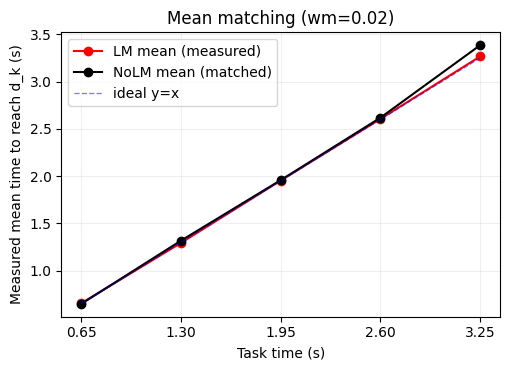

In [86]:
# wm = 0.02
plot_mean_matching(curves["02"], title=f"Mean matching (wm={0.02:.2f})")

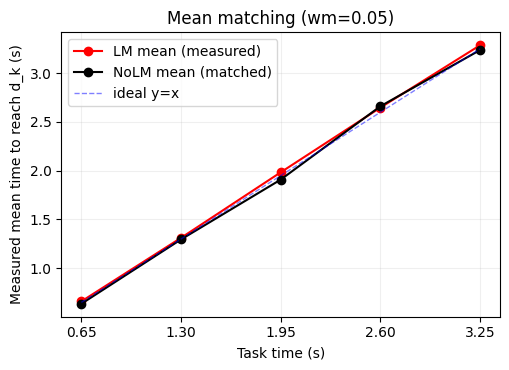

In [87]:
# wm = 0.05
plot_mean_matching(curves["05"], title=f"Mean matching (wm={0.05:.2f})")